In [ ]:
# Step 1: Import Libraries and Initialize Constants
import os
import shutil
import glob
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

In [ ]:
# For Google Colab drive mounting
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Constants and Configurations
IMG_SIZE = (224, 224)
BATCH_SIZE = 128
LEARNING_RATE = 0.0005
EPOCHS = 30
ADVERSARIAL_EPOCHS = 10  # Number of epochs for teacher adversarial training
EPSILON = 0.1
TEST_RATIO = 0.3
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Step 2: Define Models
class SimpleStudentModel(nn.Module):
    def __init__(self):
        super(SimpleStudentModel, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        # For binary classification, output two logits
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 2)

    def forward(self, x):
        return self.resnet(x)

class EnsembleModel(nn.Module):
    def __init__(self):
        super(EnsembleModel, self).__init__()
        self.densenet = models.densenet121(pretrained=True)
        self.resnet = models.resnet50(pretrained=True)
        self.efficientnet = models.efficientnet_b0(pretrained=True)

        # Freeze feature extractor parameters
        for model in [self.densenet, self.resnet, self.efficientnet]:
            for param in model.parameters():
                param.requires_grad = False

        # Replace classifier layers to produce 512-d features
        self.densenet.classifier = nn.Linear(self.densenet.classifier.in_features, 512)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 512)
        # efficientnet.classifier is typically a Sequential; replace its last layer
        self.efficientnet.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(self.efficientnet.classifier[1].in_features, 512)
        )

        # Combined classifier for binary classification
        self.classifier = nn.Linear(512 * 3, 2)

    def forward(self, x):
        x1 = self.densenet(x)
        x2 = self.resnet(x)
        x3 = self.efficientnet(x)
        x_cat = torch.cat([x1, x2, x3], dim=1)
        out = self.classifier(x_cat)
        return out

In [ ]:
# Instantiate student model
student_model = SimpleStudentModel().to(DEVICE)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 134MB/s]


In [ ]:
# Instantiate teacher model
teacher_model = EnsembleModel().to(DEVICE)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 157MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(ms

In [ ]:
# Step 3: Data Loading and Transformations
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder('/content/drive/MyDrive/BreakHis_dataset_split/train', transform=train_transforms)
validation_dataset = datasets.ImageFolder('/content/drive/MyDrive/BreakHis_dataset_split/validation', transform=test_transforms)
test_dataset = datasets.ImageFolder('/content/drive/MyDrive/BreakHis_dataset_split/test', transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

Visualizing dataset samples...


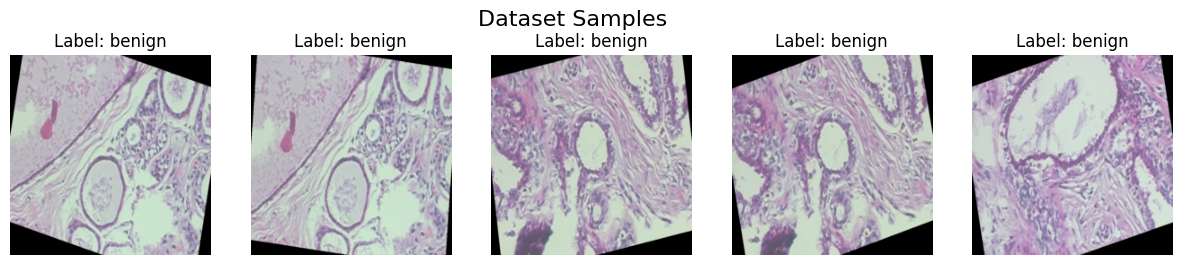

In [ ]:
# Step 4: Visualize Dataset Samples
def visualize_dataset(dataset, title="Dataset Samples", num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    fig.suptitle(title, fontsize=16)

    for i in range(num_samples):
        img, label = dataset[i]
        # Reverse normalization for display
        img = img.permute(1, 2, 0).numpy()
        img = (img * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {dataset.classes[label]}")
        axes[i].axis('off')

    plt.show()

print("Visualizing dataset samples...")
visualize_dataset(train_dataset)

In [ ]:
# Step 5: FGSM Attack Function
def fgsm_attack(model, data, target, epsilon):
    """Generate adversarial examples using the FGSM method."""
    data.requires_grad = True
    output = model(data)
    loss = nn.CrossEntropyLoss()(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data
    perturbation = epsilon * data_grad.sign()
    perturbed_data = data + perturbation
    # Ensure pixel values remain in [0,1]
    perturbed_data = torch.clamp(perturbed_data, 0, 1)
    return perturbed_data

In [ ]:
# Step 6: Plotting Functions & Attack Visualization
def plot_comparison(original, perturbation, adversarial):
    """Plot the original, perturbation, and adversarial images."""
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    # Detach the tensor from the computation graph before converting to NumPy
    plt.imshow(np.transpose(original.cpu().detach().numpy(), (1, 2, 0)))
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    # Detach the tensor from the computation graph before converting to NumPy
    plt.imshow(np.transpose(perturbation.cpu().detach().numpy(), (1, 2, 0)), cmap='coolwarm')
    plt.title("Perturbation")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    # Detach the tensor from the computation graph before converting to NumPy
    plt.imshow(np.transpose(adversarial.cpu().detach().numpy(), (1, 2, 0)))
    plt.title("Adversarial Image")
    plt.axis('off')

    plt.show()

def visualize_attack(model, data_loader, epsilon):
    model.eval()
    data, target = next(iter(data_loader))
    data, target = data.to(DEVICE), target.to(DEVICE)
    perturbed_data = fgsm_attack(model, data, target, epsilon)

    # For visualization, reverse normalization on the first image
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    original_img = inv_normalize(data[0])
    adversarial_img = inv_normalize(perturbed_data[0])
    # Compute the difference for display purposes
    perturbation_img = (adversarial_img - original_img) * 5  # amplified for visualization

    plot_comparison(original_img, perturbation_img, adversarial_img)

Visualizing attack on student model...


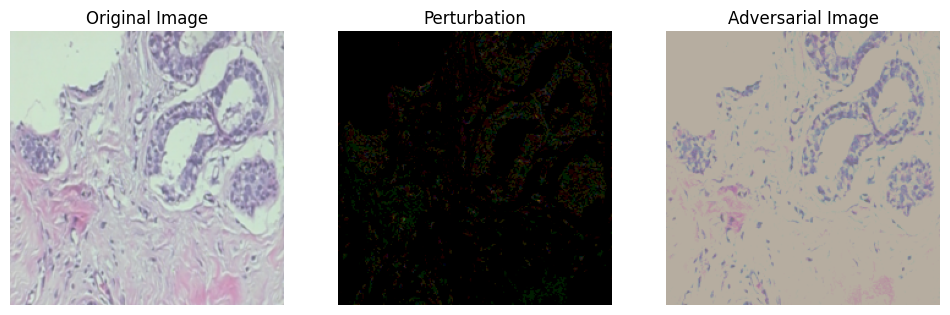

In [ ]:
# Example usage: visualize an attack on the student model
print("Visualizing attack on student model...")
visualize_attack(student_model, test_loader, epsilon=EPSILON)

Visualizing attack on student model...


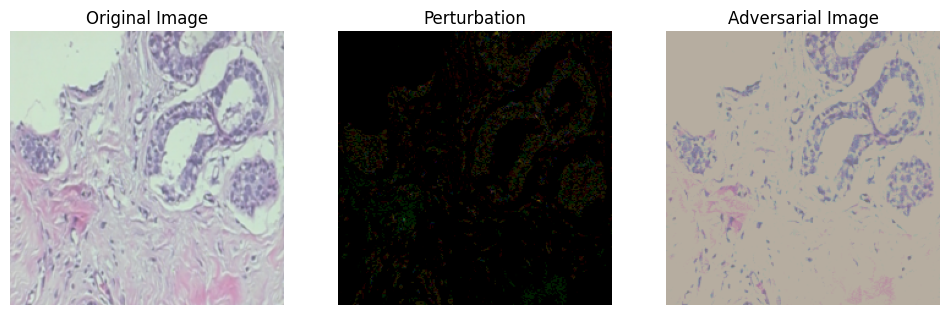

In [ ]:
# Example usage: visualize an attack on the student model
print("Visualizing attack on student model...")
visualize_attack(teacher_model, test_loader, epsilon=EPSILON)

In [ ]:
# Step 7: Training Functions
def train_student(model, train_loader, validation_loader, criterion, optimizer, scheduler, epochs, early_stopping_patience=5):
    """Train a model on clean data."""
    best_val_loss = float('inf')
    epochs_since_improvement = 0
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in tqdm(validation_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]"):
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(validation_loader)
        val_losses.append(avg_val_loss)
        scheduler.step(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_since_improvement = 0
        else:
            epochs_since_improvement += 1
            if epochs_since_improvement >= early_stopping_patience:
                print(f"Early stopping triggered at epoch {epoch+1}.")
                break

    # Plot training and validation losses
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss")
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss (Clean Data)")
    plt.legend()
    plt.grid(True)
    plt.show()

def adversarial_training(model, train_loader, criterion, optimizer, device, epsilon, epochs):
    """Train the model using adversarial examples to improve robustness."""
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for data, target in tqdm(train_loader, desc=f"Adv Training Epoch {epoch+1}/{epochs}"):
            data, target = data.to(device), target.to(device)
            data.requires_grad = True
            output = model(data)
            loss = criterion(output, target)
            model.zero_grad()
            loss.backward()
            data_grad = data.grad.data
            # Create adversarial example
            adv_data = data + epsilon * data_grad.sign()
            adv_data = torch.clamp(adv_data, 0, 1)
            # Forward pass on adversarial data
            output_adv = model(adv_data)
            loss_adv = criterion(output_adv, target)
            optimizer.zero_grad()
            loss_adv.backward()
            optimizer.step()
            running_loss += loss_adv.item()
        avg_loss = running_loss / len(train_loader)
        print(f"Adversarial Training Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training student model on clean data...


Epoch 1/30 [Validation]: 100%|██████████| 13/13 [01:48<00:00,  8.35s/it]


Epoch 1/30, Train Loss: 0.2524, Validation Loss: 0.2285


Epoch 2/30 [Validation]: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


Epoch 2/30, Train Loss: 0.1169, Validation Loss: 0.1664


Epoch 3/30 [Validation]: 100%|██████████| 13/13 [00:07<00:00,  1.63it/s]


Epoch 3/30, Train Loss: 0.1029, Validation Loss: 0.1279


Epoch 4/30 [Validation]: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]


Epoch 4/30, Train Loss: 0.0849, Validation Loss: 0.0695


Epoch 5/30 [Validation]: 100%|██████████| 13/13 [00:07<00:00,  1.63it/s]


Epoch 5/30, Train Loss: 0.0500, Validation Loss: 0.2417


Epoch 6/30 [Validation]: 100%|██████████| 13/13 [00:08<00:00,  1.61it/s]


Epoch 6/30, Train Loss: 0.0442, Validation Loss: 0.1709


Epoch 7/30 [Validation]: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]


Epoch 7/30, Train Loss: 0.0400, Validation Loss: 0.1225


Epoch 8/30 [Validation]: 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]


Epoch 8/30, Train Loss: 0.0442, Validation Loss: 0.2336


Epoch 9/30 [Validation]: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]


Epoch 9/30, Train Loss: 0.0186, Validation Loss: 0.0325


Epoch 10/30 [Validation]: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


Epoch 10/30, Train Loss: 0.0082, Validation Loss: 0.0250


Epoch 11/30 [Validation]: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


Epoch 11/30, Train Loss: 0.0059, Validation Loss: 0.0216


Epoch 12/30 [Validation]: 100%|██████████| 13/13 [00:07<00:00,  1.63it/s]


Epoch 12/30, Train Loss: 0.0051, Validation Loss: 0.0204


Epoch 13/30 [Validation]: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]


Epoch 13/30, Train Loss: 0.0037, Validation Loss: 0.0213


Epoch 14/30 [Validation]: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


Epoch 14/30, Train Loss: 0.0033, Validation Loss: 0.0224


Epoch 15/30 [Validation]: 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]


Epoch 15/30, Train Loss: 0.0033, Validation Loss: 0.0186


Epoch 16/30 [Validation]: 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]


Epoch 16/30, Train Loss: 0.0028, Validation Loss: 0.0204


Epoch 17/30 [Validation]: 100%|██████████| 13/13 [00:07<00:00,  1.63it/s]


Epoch 17/30, Train Loss: 0.0024, Validation Loss: 0.0257


Epoch 18/30 [Validation]: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


Epoch 18/30, Train Loss: 0.0021, Validation Loss: 0.0208


Epoch 19/30 [Validation]: 100%|██████████| 13/13 [00:08<00:00,  1.61it/s]


Epoch 19/30, Train Loss: 0.0013, Validation Loss: 0.0209


Epoch 20/30 [Validation]: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


Epoch 20/30, Train Loss: 0.0013, Validation Loss: 0.0207
Early stopping triggered at epoch 20.


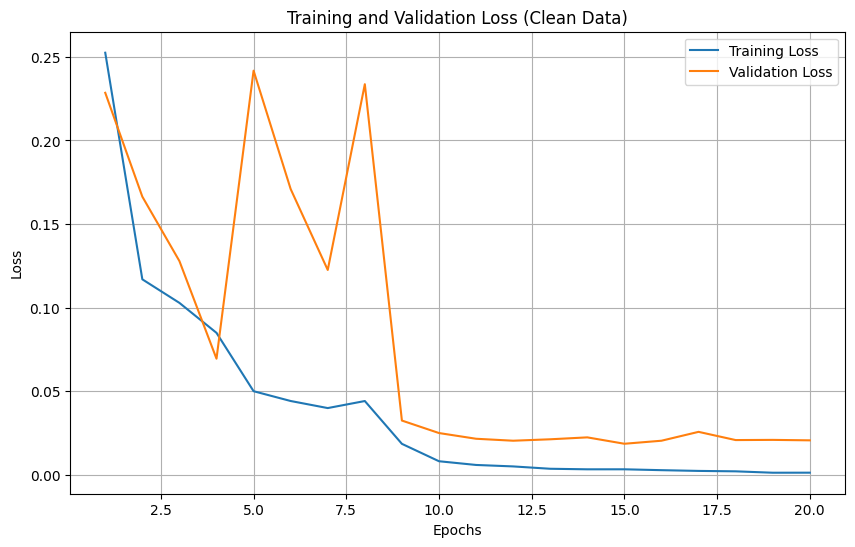

In [ ]:
# Step 8: Train the Student Model (Detection Model) on Clean Data
print("Training student model on clean data...")
criterion = nn.CrossEntropyLoss()
optimizer_student = optim.Adam(student_model.parameters(), lr=LEARNING_RATE)
scheduler_student = optim.lr_scheduler.ReduceLROnPlateau(optimizer_student, mode='min', patience=3, verbose=True)
train_student(student_model, train_loader, validation_loader, criterion, optimizer_student, scheduler_student, EPOCHS)

In [ ]:
# Step 9: Save the student Model
torch.save(student_model, '/content/drive/MyDrive/Submission/student_model_BreakHis_full_trainingV1.0.pth')
print("Models saved successfully!")

Models saved successfully!


In [ ]:
# Step 10: Adversarial Training of the Teacher Model (Defense Model)
print("Starting adversarial training for teacher model...")
criterion_teacher = nn.CrossEntropyLoss()
optimizer_teacher = optim.Adam(teacher_model.parameters(), lr=0.0001)
adversarial_training(teacher_model, train_loader, criterion_teacher, optimizer_teacher, DEVICE, EPSILON, ADVERSARIAL_EPOCHS)

Starting adversarial training for teacher model...


Adv Training Epoch 1/10: 100%|██████████| 60/60 [00:50<00:00,  1.19it/s]


Adversarial Training Epoch 1/10, Loss: 0.6360


Adv Training Epoch 2/10: 100%|██████████| 60/60 [00:49<00:00,  1.21it/s]


Adversarial Training Epoch 2/10, Loss: 0.5802


Adv Training Epoch 3/10: 100%|██████████| 60/60 [00:49<00:00,  1.21it/s]


Adversarial Training Epoch 3/10, Loss: 0.5710


Adv Training Epoch 4/10: 100%|██████████| 60/60 [00:49<00:00,  1.21it/s]


Adversarial Training Epoch 4/10, Loss: 0.5661


Adv Training Epoch 5/10: 100%|██████████| 60/60 [00:49<00:00,  1.20it/s]


Adversarial Training Epoch 5/10, Loss: 0.5545


Adv Training Epoch 6/10: 100%|██████████| 60/60 [00:49<00:00,  1.21it/s]


Adversarial Training Epoch 6/10, Loss: 0.5520


Adv Training Epoch 7/10: 100%|██████████| 60/60 [00:49<00:00,  1.21it/s]


Adversarial Training Epoch 7/10, Loss: 0.5467


Adv Training Epoch 8/10: 100%|██████████| 60/60 [00:49<00:00,  1.21it/s]


Adversarial Training Epoch 8/10, Loss: 0.5471


Adv Training Epoch 9/10: 100%|██████████| 60/60 [00:49<00:00,  1.21it/s]


Adversarial Training Epoch 9/10, Loss: 0.5501


Adv Training Epoch 10/10: 100%|██████████| 60/60 [00:49<00:00,  1.20it/s]

Adversarial Training Epoch 10/10, Loss: 0.5457


In [ ]:
# Step 11: Save the teacher Model
torch.save(teacher_model, '/content/drive/MyDrive/Submission/teacher_model_BreakHis_full_trainingV1.0.pth')
print("Models saved successfully!")

Models saved successfully!


Evaluating student model on clean data...
Student Model Accuracy on Clean Data: 99.69%
Evaluating student model under FGSM attack...
Epsilon 0.01: Accuracy = 41.80%
Epsilon 0.05: Accuracy = 37.26%
Epsilon 0.1: Accuracy = 35.42%
Epsilon 0.2: Accuracy = 40.33%
Epsilon 0.3: Accuracy = 45.98%


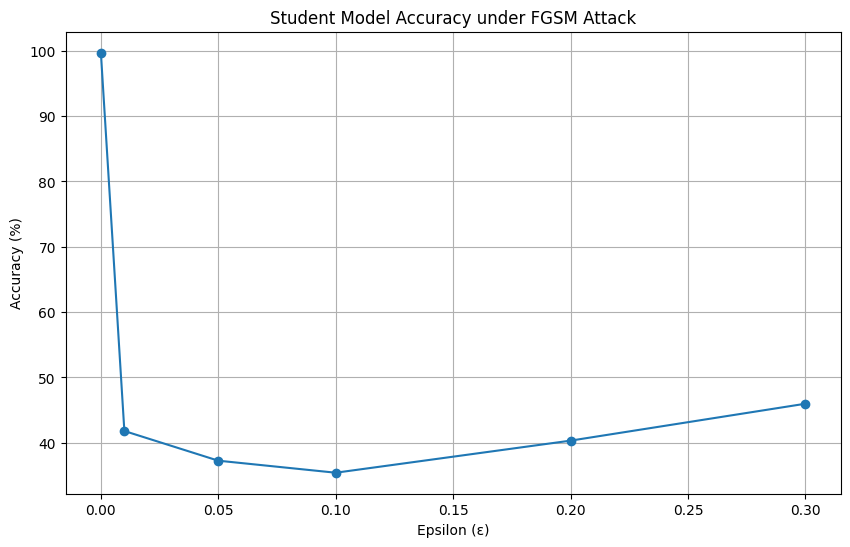

In [ ]:
# Step 12: Evaluate the Student Model Before and After FGSM Attack
def evaluate_model(model, loader, device, epsilon=0):
    model.eval()
    correct = 0
    total = 0
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        if epsilon > 0:
            data = fgsm_attack(model, data, target, epsilon)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)
    accuracy = 100. * correct / total
    return accuracy

print("Evaluating student model on clean data...")
student_clean_acc = evaluate_model(student_model, test_loader, DEVICE)
print(f"Student Model Accuracy on Clean Data: {student_clean_acc:.2f}%")

print("Evaluating student model under FGSM attack...")
epsilon_values = [0.01, 0.05, 0.1, 0.2, 0.3]
student_attack_acc = []
for eps in epsilon_values:
    acc = evaluate_model(student_model, test_loader, DEVICE, eps)
    student_attack_acc.append(acc)
    print(f"Epsilon {eps}: Accuracy = {acc:.2f}%")

plt.figure(figsize=(10, 6))
plt.plot([0] + epsilon_values, [student_clean_acc] + student_attack_acc, marker='o')
plt.xlabel("Epsilon (ε)")
plt.ylabel("Accuracy (%)")
plt.title("Student Model Accuracy under FGSM Attack")
plt.grid(True)
plt.show()